In [4]:
%matplotlib inline
from IPython.display import Image
from qiskit import *
from qiskit_ibm_runtime import *
from qiskit.quantum_info import Statevector
from qiskit.visualization import *
from qiskit_aer import *

# Cargar credenciales de IBM Quantum
service = QiskitRuntimeService()

### Aprendiendo sobre los efectos de la interferencia entre cúbits

Uno de los beneficios de la computación cuántica es su capacidad para entrelazar estos principios de tal manera que, al explicar uno, se puede describir fácilmente el otro. Hicimos esto anteriormente con respecto a la interferencia. Vamos a revisarlo y ver dónde hemos encontrado este fenómeno y su uso hasta ahora.

Primero, recuerda que, al inicio de este capítulo, describimos el experimento de la doble rendija. Allí, discutimos cómo un electrón puede actuar como una onda y como una partícula. Al actuar como una onda, vimos que el experimento ilustraba cómo los electrones viajaban y aterrizaban en ciertos puntos de la pantalla de observación. El patrón que mostraban era generalmente uno que reconocemos de la física clásica como interferencia de ondas.

El patrón tenía resultados probabilísticos a lo largo de la pantalla, como se muestra en la pantalla de observación. El centro de la pantalla tiene la mayor cantidad de electrones, y las áreas vacías a ambos lados tienen poco o ningún electrón. Esto se debe a la interferencia constructiva y destructiva de las ondas.

Hay dos tipos de interferencia, a saber:

1. **Constructiva**: La interferencia constructiva ocurre cuando los picos de dos ondas se suman y la amplitud resultante es igual a la suma positiva total de las dos ondas individuales.

2. **Destructiva**: La interferencia destructiva ocurre de manera similar a la interferencia constructiva, excepto que las amplitudes de las ondas son opuestas; al sumarlas, las ondas se cancelan entre sí.

El siguiente diagrama ilustra la interferencia constructiva y destructiva de las ondas cuando se combinan:

![image.png](./Class_01/Figures/interference.png)

Uno proviene del estado base $ |0\rangle $, mientras que el otro proviene del estado base $ |1\rangle $.  
**¿Recuerdas cuando partimos de uno de estos dos estados base de cúbits y preguntamos en qué lugar del eje X aterrizaría el qubit tras aplicar la puerta Hadamard?**  
Desde $ |0\rangle $, aterrizaría en el lado positivo del eje X, pero si colocáramos el cúbit en superposición partiendo del estado $ |1\rangle $, aterrizaría en el lado negativo del eje X.

Tener la capacidad de colocar el vector de estado del cúbit en el lado positivo o negativo del eje X nos permite ubicar el cúbit en un estado positivo o negativo. Muy similar a las ondas del diagrama anterior, que tienen amplitudes positivas (picos) y negativas (valles), los cúbits también pueden representar estados similares. Simplifiquemos esto reintroduciendo los dos valores en notación de Dirac: $ |+\rangle $ y $ |-\rangle $, donde:

- El estado $ |+\rangle $ representa el vector de estado en el lado positivo del eje X.
- El estado $ |-\rangle $ representa el vector de estado en el lado negativo del eje X.

Estas nuevas definiciones de vectores, que representan el estado vectorial de un cúbit en superposición, serán utilizadas por algunos algoritmos como una técnica para identificar ciertos valores y reaccionar a ellos utilizando interferencia. Esto incluye técnicas como **estimación de amplitud** o algoritmos de búsqueda como el **algoritmo de Grover**.


# Creando un circuito de teletransportación cuántica

En esta sección, crearemos un circuito de teletransportación cuántica para compartir el estado, $ |\psi\rangle $, de un qubit mediante la comunicación clásica de dos bits de información. ¿Por qué necesitaría compartir dos bits de información y no solo el estado del cúbit en sí? Bueno, la respuesta radica en el **teorema de no-clonación**.

Sin entrar en las pruebas de mecánica cuántica, el teorema establece que crear una copia de un cúbit a partir de un estado desconocido arbitrario no es posible, ya que no existe un operador unitario que pueda clonar todos los estados de un qubit en otro. Dicho esto, necesitamos buscar otros medios para transferir el estado de un qubit a otro. La **teletransportación cuántica** nos ayuda a lograrlo.

Para entender correctamente este ejemplo, echemos un vistazo al proceso general. Luego, podemos profundizar en los detalles y ver cómo podemos hacerlo posible. Como se mencionó anteriormente, el objetivo es tener un emisor —llamémosla Alice— que tiene un qubit en un estado arbitrario $ |\psi\rangle = \alpha|0\rangle + \beta|1\rangle $ y proporciona dos bits de información al receptor —llamémoslo Bob.

Alice luego enviará información a Bob de forma clásica (como comunicarse por llamada telefónica o mensaje de texto), quien realizará operaciones en un qubit que le permitirán generar el estado que Alice tenía. Decimos que **Alice tenía** ese estado porque, para enviar la información de los bits a Bob, Alice necesita realizar una medición en el estado arbitrario del qubit, lo que colapsará en valores binarios. Por lo tanto, se perderá toda la información cuántica del qubit.

Para ilustrar esto, vamos a crear un circuito que siga esta idea.

1. Ahora tenemos tres cúbits. El primer cúbit (`q[0]`) representará el estado desconocido $ |\psi\rangle $. El segundo y tercer cúbit (`q[1]` y `q[2]`) serán los cúbits entrelazados compartidos entre Alice y Bob, respectivamente.

In [6]:
# Crear el circuito de 3 qubits
qreg_q = QuantumRegister(3, 'q')
creg_c = ClassicalRegister(3, 'c')
qc = QuantumCircuit(qreg_q, creg_c)

2. Prepararemos el primer cúbit (`q[0]`) en un estado $ |\psi\rangle $ desconocido que ni Alice ni Bob sabrán. Por supuesto, nosotros lo conoceremos al crearlo. Sin embargo, la idea aquí es visualizar el estado desde el contexto de Alice y Bob. Para mantener este ejemplo simple, se aplicarán dos operadores unitarios: una puerta NOT y una puerta Z.

***Nota*** que se añadió una barrera después de establecer el estado $ |\psi\rangle $. Esto es simplemente para facilitar la visualización del circuito cuando lo dibujemos, para identificar a qué componente corresponde cada sección. En este caso, se trata del primer bloque que especifica $ |\psi\rangle $

In [7]:
qc.x(0)
qc.z(0)
qc.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=3, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(3, 'q'), 0), Qubit(QuantumRegister(3, 'q'), 1), Qubit(QuantumRegister(3, 'q'), 2)), clbits=())

3. Ahora que hemos preparado nuestro estado, que es conocido por nosotros pero desconocido tanto para Alice como para Bob, pasaremos al siguiente paso en nuestro diagrama de flujo: que Alice entrelace los otros dos cúbits (`q[1]` y `q[2]`) juntos. Alice conservará el qubit `q[1]` y enviará el qubit `q[2]` a Bob. Para entrelazar los dos qubits, aplicaremos una puerta Hadamard al qubit de Alice (`q[1]`), seguida de una puerta CNOT entre los dos qubits, donde el control está conectado al qubit de Alice y el objetivo está conectado al qubit de Bob. Incluiremos una barrera aquí, como hicimos anteriormente, para segmentar esta preparación.


In [8]:
qc.h(1)
qc.cx(1, 2)
qc.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=3, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(3, 'q'), 0), Qubit(QuantumRegister(3, 'q'), 1), Qubit(QuantumRegister(3, 'q'), 2)), clbits=())

4. Ahora pasaremos al siguiente bloque, donde Alice entrelazará el qubit en el estado $ |\psi\rangle $ con su qubit que estaba entrelazado con el de Bob. Luego, se aplicará una puerta Hadamard antes de medir tanto el qubit $ |\psi\rangle $ como su qubit entrelazado.

In [9]:
qc.cx(0, 1)
qc.h(0)
qc.measure(qreg_q[0], creg_c[0])
qc.measure(qreg_q[1], creg_c[1])
qc.barrier()
qc.cx(1, 2)
qc.barrier()

CircuitInstruction(operation=Instruction(name='barrier', num_qubits=3, num_clbits=0, params=[]), qubits=(Qubit(QuantumRegister(3, 'q'), 0), Qubit(QuantumRegister(3, 'q'), 1), Qubit(QuantumRegister(3, 'q'), 2)), clbits=())

5. Después de medir los dos qubits, $ |\psi\rangle $ y `q[1]`, Alice llama a Bob y le informa sus resultados. Luego, Bob aplica las puertas necesarias según los resultados de Alice, como se ilustra en el siguiente bloque de nuestro diagrama de flujo. Bob aplicará las puertas correspondientes según la información que obtuvo de Alice. La operación unitaria que se aplica se basa en una de las siguientes nociones:  
   - `00`: Usar la puerta de identidad (I).  
   - `01`: Usar la puerta X (NOT).  
   - `10`: Usar la puerta Z.  
   - `11`: Usar la puerta Z seguida de la puerta X.

6. Dado que ejecutaremos el circuito con 1,024 repeticiones, deberíamos esperar ver todos los resultados anteriores. **¿Cómo podemos determinar si los resultados son correctos?**

   Podemos verificar esto aplicando las puertas que usamos para preparar $ |\psi\rangle $, pero en orden inverso. Recuerda del paso 1 que los operadores unitarios deben ser reversibles. Aplicaremos primero una puerta Z, luego una puerta NOT al qubit de Bob. Si todo va bien, deberíamos esperar que el resultado del qubit de Bob siempre sea $ |0\rangle $.

   Después de esta medición, el resultado en el bit clásico (2) debería ser 0 para todos los resultados.




In [10]:
qc.z(2)
qc.x(2) 
qc.measure(qreg_q[2], creg_c[2])

7. Ahora, tracemos el circuito para ver lo que hemos creado hasta ahora. Recuerda que cada segmento, separado por una barrera, pertenece al paso correspondiente del diagrama de flujo, donde el último segmento simplemente verifica que hemos transportado con éxito $ |\psi\rangle $. 

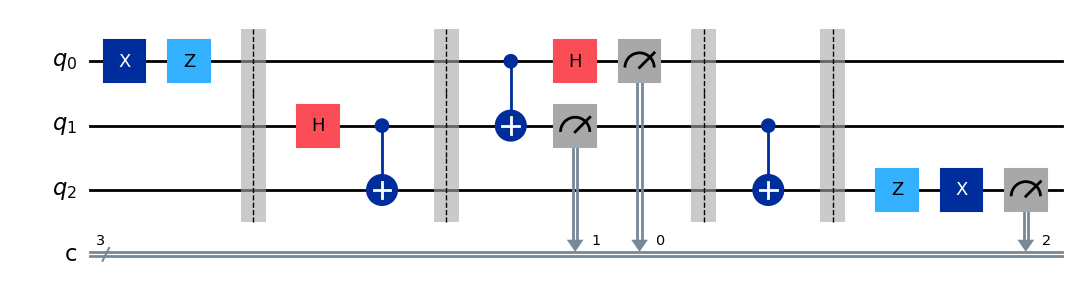

In [11]:
qc.draw(output='mpl')

El circuito anterior muestra que las barreras (líneas punteadas) separan visualmente el circuito, facilitando su segmentación y comprensión. 

- **Primer segmento**: Aquí es donde Alice prepara su qubit.  
- **Segundo segmento**: Entrelaza dos qubits, donde `q1` pertenece a Alice y `q2` pertenece a Bob.  
- **Tercer segmento**: Alice entrelaza su qubit preparado `q0` con su qubit compartido `q1`. Luego realiza una medición de los resultados de sus dos qubits.

El último segmento que Bob lee recibe la respuesta clásica de Alice (a través de `q1`) y la codifica en su qubit. Esto se representa aquí en el orden inverso de cómo Alice preparó su qubit en el primer segmento. Esto es porque las operaciones en los qubits deben ser reversibles, razón por la cual Bob aplica primero una puerta Z y luego una puerta X. Finalmente, cuando Bob mide su qubit, debería obtener el resultado esperado, \( 0 \), que es el estado inicial que Alice tenía. Si este resultado es diferente de \( 0 \), Bob puede determinar que el qubit fue alterado durante la transmisión.

8. Confirmación del estado final
Ahora podemos confirmar si el estado que tiene Bob es el mismo que Alice tenía previamente (colapsado y medido como $ |\psi\rangle $. Ejecutaremos esto en el simulador `qasm` con 1,024 repeticiones.

In [18]:
# ejecutar el circuito en el simulador de Aer
backend = Aer.get_backend('qasm_simulator')
tqc = transpile(qc, backend)
result = backend.run(tqc, shots = 1024).result()
print(result.get_counts())

{'011': 278, '001': 246, '000': 265, '010': 235}


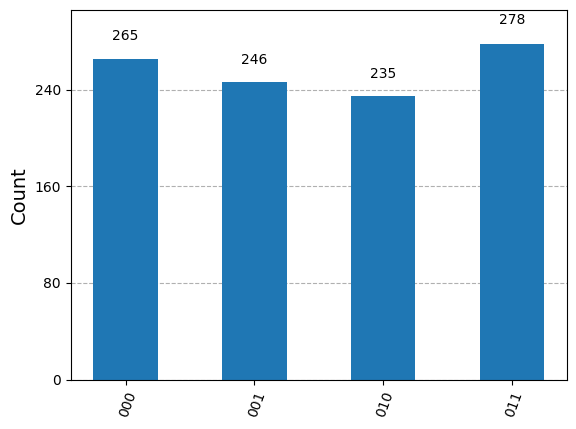

In [19]:
from qiskit.visualization import plot_histogram

counts = result.get_counts()
plot_histogram(counts)


Ahora imprimiremos los resultados en un histograma para confirmar que recuperamos todos los estados desde `00` hasta `11`, como se ilustró anteriormente en el paso 4, solo para asegurarnos de que el bit clásico principal (el bit más a la izquierda) siempre sea $0$. Los resultados del circuito ejecutado muestran que los resultados del bit clásico más a la izquierda siempre son $0$ y que los dos bits clásicos corresponden a los estados `00` a `11`.

En este ejemplo, creamos un circuito que transporta el estado de un qubit de una persona a otra utilizando un conjunto de qubits entrelazados para transmitir información de Alice a Bob.


# Resumen

En este capítulo, aprendiste sobre los tres principios de la computación cuántica utilizados en la computación cuántica y la teletransportación cuántica. Creamos un circuito cuántico y colocamos un qubit en superposición, así como en un estado entrelazado entre dos qubits en un circuito cuántico.

También entendimos los dos tipos de interferencia, constructiva y destructiva, y aprendimos cómo se notan y representan individualmente como qubits al colocarlos en superposición para crear las simulaciones $ |+\rangle $ y $ |-\rangle $. Además, aprendimos cómo transferir información de estado de una persona a otra utilizando la teletransportación cuántica.

También tuviste un adelanto de algunas habilidades de desarrollo en Qiskit al utilizar puertas cuánticas como la Hadamard y la Control-Not, así como operaciones como mediciones. Esto te preparará para los capítulos futuros, cuando crearás circuitos donde estas puertas y operaciones se utilizan comúnmente en varios algoritmos. Esto tiene sentido ya que estas puertas y operaciones representan los principios básicos de la computación cuántica que hemos aprendido.

En el próximo capítulo, aprenderemos sobre todas las demás puertas, tanto de un solo qubit como de múltiples qubits, para entender las operaciones que realizan en cada qubit.

## Preguntas

1. ¿Cómo crearías un circuito que entrelace dos qubits donde cada qubit sea diferente (es decir, `01`, `10`)?
2. ¿Qué simulador se utiliza para mostrar la esfera de Bloch?
3. Ejecuta el experimento de superposición con el parámetro `shots=1`, luego con `shots=1000`, y finalmente con `shots=8000`. ¿Cuál es la diferencia?
4. Ejecuta el experimento de teletransportación cuántica en un dispositivo cuántico real y describe los resultados en comparación con los del simulador. ¿Qué es diferente, si es que hay alguna diferencia, y por qué? (Pista: el ruido afecta a los dispositivos de corto plazo).

